In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

In [2]:
api_calls_day = pd.Timestamp('2019-06-13')
churn_cutoff = api_calls_day - pd.Timedelta(3,'M')

In [3]:
df_friend_summary = pd.read_csv('100k_friend_summary.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_profile_summary = pd.read_csv('100k_clean_player_info.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_per_game_summary = pd.read_csv('100k_per_game.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_game_per_user_summary = pd.read_csv('100k_game_per_user.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_top5game_per_user_summary = pd.read_csv('100k_top5game_per_user.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')

In [4]:
df_full_prof = df_friend_summary.merge(df_profile_summary,on='steamid',how='right')

In [5]:
df_full_prof = df_full_prof.drop(['lastlogoff_readable','timecreated_readable','newest_friend_steamid', 'oldest_friend_steamid', 'Root', 'First_tier', 'Second_tier', 'Third_tier','realname', 'personaname', 'loccityid', 'loccountrycode', 'locstatecode'],axis='columns')

In [6]:
df_full_prof = df_full_prof.merge(df_game_per_user_summary,on='steamid',how='left')

In [7]:
df_full_prof.fillna(0,inplace=True)

In [8]:
print(churn_cutoff)

2019-03-13 16:32:42


In [9]:
df_full_prof['isChurned'] = df_full_prof['lastlogoff'].map(lambda x: 1 if (pd.to_datetime(x, unit='s') < churn_cutoff) else 0)


In [10]:
df_friend_full = pd.read_csv('player_friend_info_100k.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')

In [11]:
df_friend_full = df_friend_full[pd.to_datetime(df_friend_full['friend_since'], unit='s') < churn_cutoff]

In [12]:
df_friend_large = pd.merge(df_friend_full,df_full_prof,on='steamid')

In [13]:
df_friend_large = df_friend_large.drop(['relationship','friend_since','newest_friend_time','oldest_friend_time','lastlogoff','profilestate','timecreated','isPublic','isFriendsOnly','isPrivate','playtime_forever_max','playtime_forever_std','playtime_forever_std_noZero'],axis='columns')


In [14]:
df_friends_list = pd.DataFrame(df_friend_large.groupby('steamid_orig')['steamid'].apply(list))

In [15]:
df_friends_list = df_friends_list.add_suffix('_friend_list')
df_friends_list = df_friends_list.reset_index()
df_friends_list['steamid'] = df_friends_list['steamid_orig']
df_friends_list = df_friends_list.drop('steamid_orig',axis='columns')

In [16]:
df_friends_mean = pd.DataFrame(df_friend_large.drop(['steamid','appid_max'],axis='columns').groupby('steamid_orig').mean())

In [17]:
df_friends_mean = df_friends_mean.add_suffix('_friends_mean')

In [18]:
df_friends_mean = df_friends_mean.reset_index()
df_friends_mean['steamid'] = df_friends_mean['steamid_orig']
df_friends_mean = df_friends_mean.drop('steamid_orig',axis='columns')

In [19]:
df_friends_mode = pd.DataFrame(df_friend_large[df_friend_large['appid_max'] != 0].groupby('steamid_orig')['appid_max'].apply(pd.Series.mode))

In [20]:
df_friends_mode = df_friends_mode.reset_index().drop('level_1',axis='columns')
df_friends_mode['steamid'] = df_friends_mode['steamid_orig']
df_friends_mode['friends_fav_appid'] = df_friends_mode['appid_max']
df_friends_mode = df_friends_mode.drop('steamid_orig',axis='columns')
df_friends_mode = df_friends_mode.drop('appid_max',axis='columns')
df_friends_mode = df_friends_mode.drop_duplicates(['steamid'],keep='first')
df_friends_mode.info()
print(df_friends_mode['steamid'].nunique())
print(df_friends_mean['steamid'].nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65214 entries, 0 to 105551
Data columns (total 2 columns):
steamid              65214 non-null int64
friends_fav_appid    65214 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB
65214
84637


In [21]:
df_friends_stats = pd.merge(df_friends_mean,df_friends_mode,on='steamid',how='outer')

In [22]:
df_friends_temp = df_full_prof.merge(df_friends_stats,on='steamid',how='left')

In [23]:
df_friends_temp['steamid'].nunique()

88555

In [24]:
df_dup_steamid = df_friends_temp[df_friends_temp.duplicated(['steamid'],keep=False)]

In [25]:
df_dup_steamid

,num_Friends,steamid,newest_friend_time,oldest_friend_time,commentpermission,lastlogoff,profilestate,timecreated,costom_avatar,isPublic,...,commentpermission_friends_mean,costom_avatar_friends_mean,inClan_friends_mean,playtime_forever_sum_friends_mean,appid_count_friends_mean,playtime_forever_mean_friends_mean,appid_count_noZero_friends_mean,playtime_forever_mean_noZero_friends_mean,isChurned_friends_mean,friends_fav_appid


In [26]:
df_friends_temp.fillna(0,inplace=True)

In [27]:
df_friends_temp['Same_fav_as_friend'] = df_friends_temp.apply(lambda x: 1 if x['appid_max'] == x['friends_fav_appid'] else 0,axis=1)

In [28]:
df_friends_temp['num_Zero_games'] = df_friends_temp['appid_count'] - df_friends_temp['appid_count_noZero']

In [30]:
df_full_prof = df_friends_temp

In [31]:
df_churned = df_full_prof[df_full_prof['isChurned'] == 1]

In [32]:
df_active = df_full_prof[df_full_prof['isChurned'] == 0]

In [33]:
from sklearn.model_selection import train_test_split
df_churned_train, df_churned_test = train_test_split(df_churned,test_size=0.2,random_state=1234)

In [34]:
df_active_remain, df_active_test = train_test_split(df_active,test_size=0.2,random_state=1234)

In [35]:
df_active_extra, df_active_train = train_test_split(df_active_remain,test_size=len(df_churned_train),random_state=1234)

In [36]:
df_train = pd.concat([df_active_train,df_churned_train])

In [37]:
df_test = pd.concat([df_active_test,df_churned_test])

In [38]:
X_train = df_train.drop(['steamid','isPublic','isFriendsOnly','isPrivate','inClan','appid_count','playtime_forever_mean','lastlogoff','isChurned','appid_max','commentpermission_friends_mean','appid_count_friends_mean','friends_fav_appid','playtime_forever_mean_friends_mean','isChurned_friends_mean','inClan_friends_mean'],axis='columns')
X_test = df_test.drop(['steamid','isPublic','isFriendsOnly','isPrivate','inClan','appid_count','playtime_forever_mean','lastlogoff','isChurned','appid_max','commentpermission_friends_mean','appid_count_friends_mean','friends_fav_appid','playtime_forever_mean_friends_mean','isChurned_friends_mean','inClan_friends_mean'],axis='columns')
y_train = df_train['isChurned']
y_test = df_test['isChurned']

In [39]:
X_train.columns

Index(['num_Friends', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'profilestate', 'timecreated', 'costom_avatar',
       'playtime_forever_sum', 'playtime_forever_std', 'playtime_forever_max',
       'appid_count_noZero', 'playtime_forever_mean_noZero',
       'playtime_forever_std_noZero', 'num_Friends_friends_mean',
       'costom_avatar_friends_mean', 'playtime_forever_sum_friends_mean',
       'appid_count_noZero_friends_mean',
       'playtime_forever_mean_noZero_friends_mean', 'Same_fav_as_friend',
       'num_Zero_games'],
      dtype='object')

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [41]:
log_model = LogisticRegression(random_state=10,solver='lbfgs')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/anaconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [42]:
log_model.fit(X_train_scaled,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

# Validate on Training Data (Equalized Population Ratio)

[[7295 3775]
 [2324 8746]]


              precision    recall  f1-score   support

           0       0.76      0.66      0.71     11070
           1       0.70      0.79      0.74     11070

   micro avg       0.72      0.72      0.72     22140
   macro avg       0.73      0.72      0.72     22140
weighted avg       0.73      0.72      0.72     22140



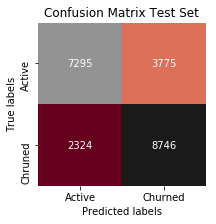

In [92]:
from sklearn.metrics import confusion_matrix, classification_report
axis = plt.figure(figsize=(3,3))
log_pred = log_model.predict(X_train_scaled)
cm = confusion_matrix(y_train,log_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d',ax = ax,cmap='RdGy',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Test Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_train,log_pred))

In [83]:
prob_class_active = []
prob_class_churned = []
for x in log_model.predict_proba(X_train_scaled):
    prob_class_active.append(x[0])
    prob_class_churned.append(x[1])
df_train['Prob_Active_Log'] = prob_class_active
df_train['Prob_Churned_Log'] = prob_class_churned

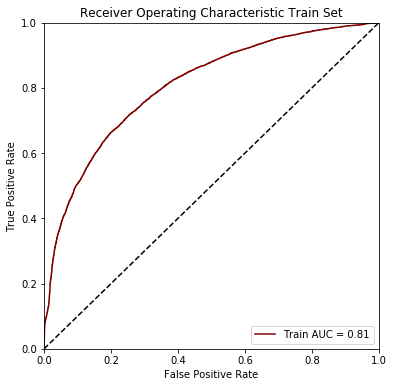

In [97]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_train, df_train['Prob_Churned_Log'], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic Train Set')
plt.plot(fpr, tpr, 'maroon',label = 'Train AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

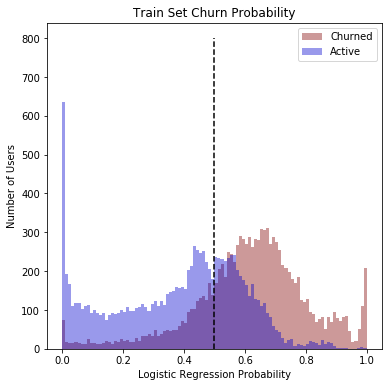

In [100]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_train['Prob_Churned_Log'][df_train['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_train['Prob_Churned_Log'][df_train['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Train Set Churn Probability")
plt.show()

# Validate on Test Data (True Population Ratio)

[[9689 5255]
 [ 591 2177]]


              precision    recall  f1-score   support

           0       0.94      0.65      0.77     14944
           1       0.29      0.79      0.43      2768

   micro avg       0.67      0.67      0.67     17712
   macro avg       0.62      0.72      0.60     17712
weighted avg       0.84      0.67      0.71     17712



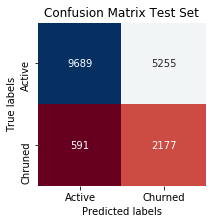

In [82]:
axis = plt.figure(figsize=(3,3))
log_pred = log_model.predict(X_test_scaled)
cm = confusion_matrix(y_test,log_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d',ax = ax,cmap='RdBu',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Test Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_test,log_pred))

In [53]:
prob_class_active = []
prob_class_churned = []
for x in log_model.predict_proba(X_test_scaled):
    prob_class_active.append(x[0])
    prob_class_churned.append(x[1])
df_test['Prob_Active_Log'] = prob_class_active
df_test['Prob_Churned_Log'] = prob_class_churned

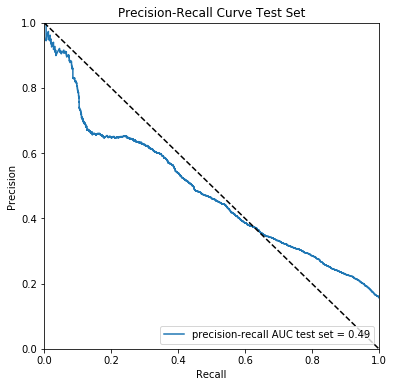

In [77]:
precision, recall, threshold = metrics.precision_recall_curve(y_test, df_test['Prob_Churned_Log'], pos_label=1)
roc_auc = metrics.auc(recall, precision)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Precision-Recall Curve Test Set')
plt.plot(recall, precision, label = 'precision-recall AUC test set = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [111]:
df_train['False_Pos'] = ((df_train['Prob_Churned_Log'] > 0.4) & (df_train['isChurned'] == 0))

/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


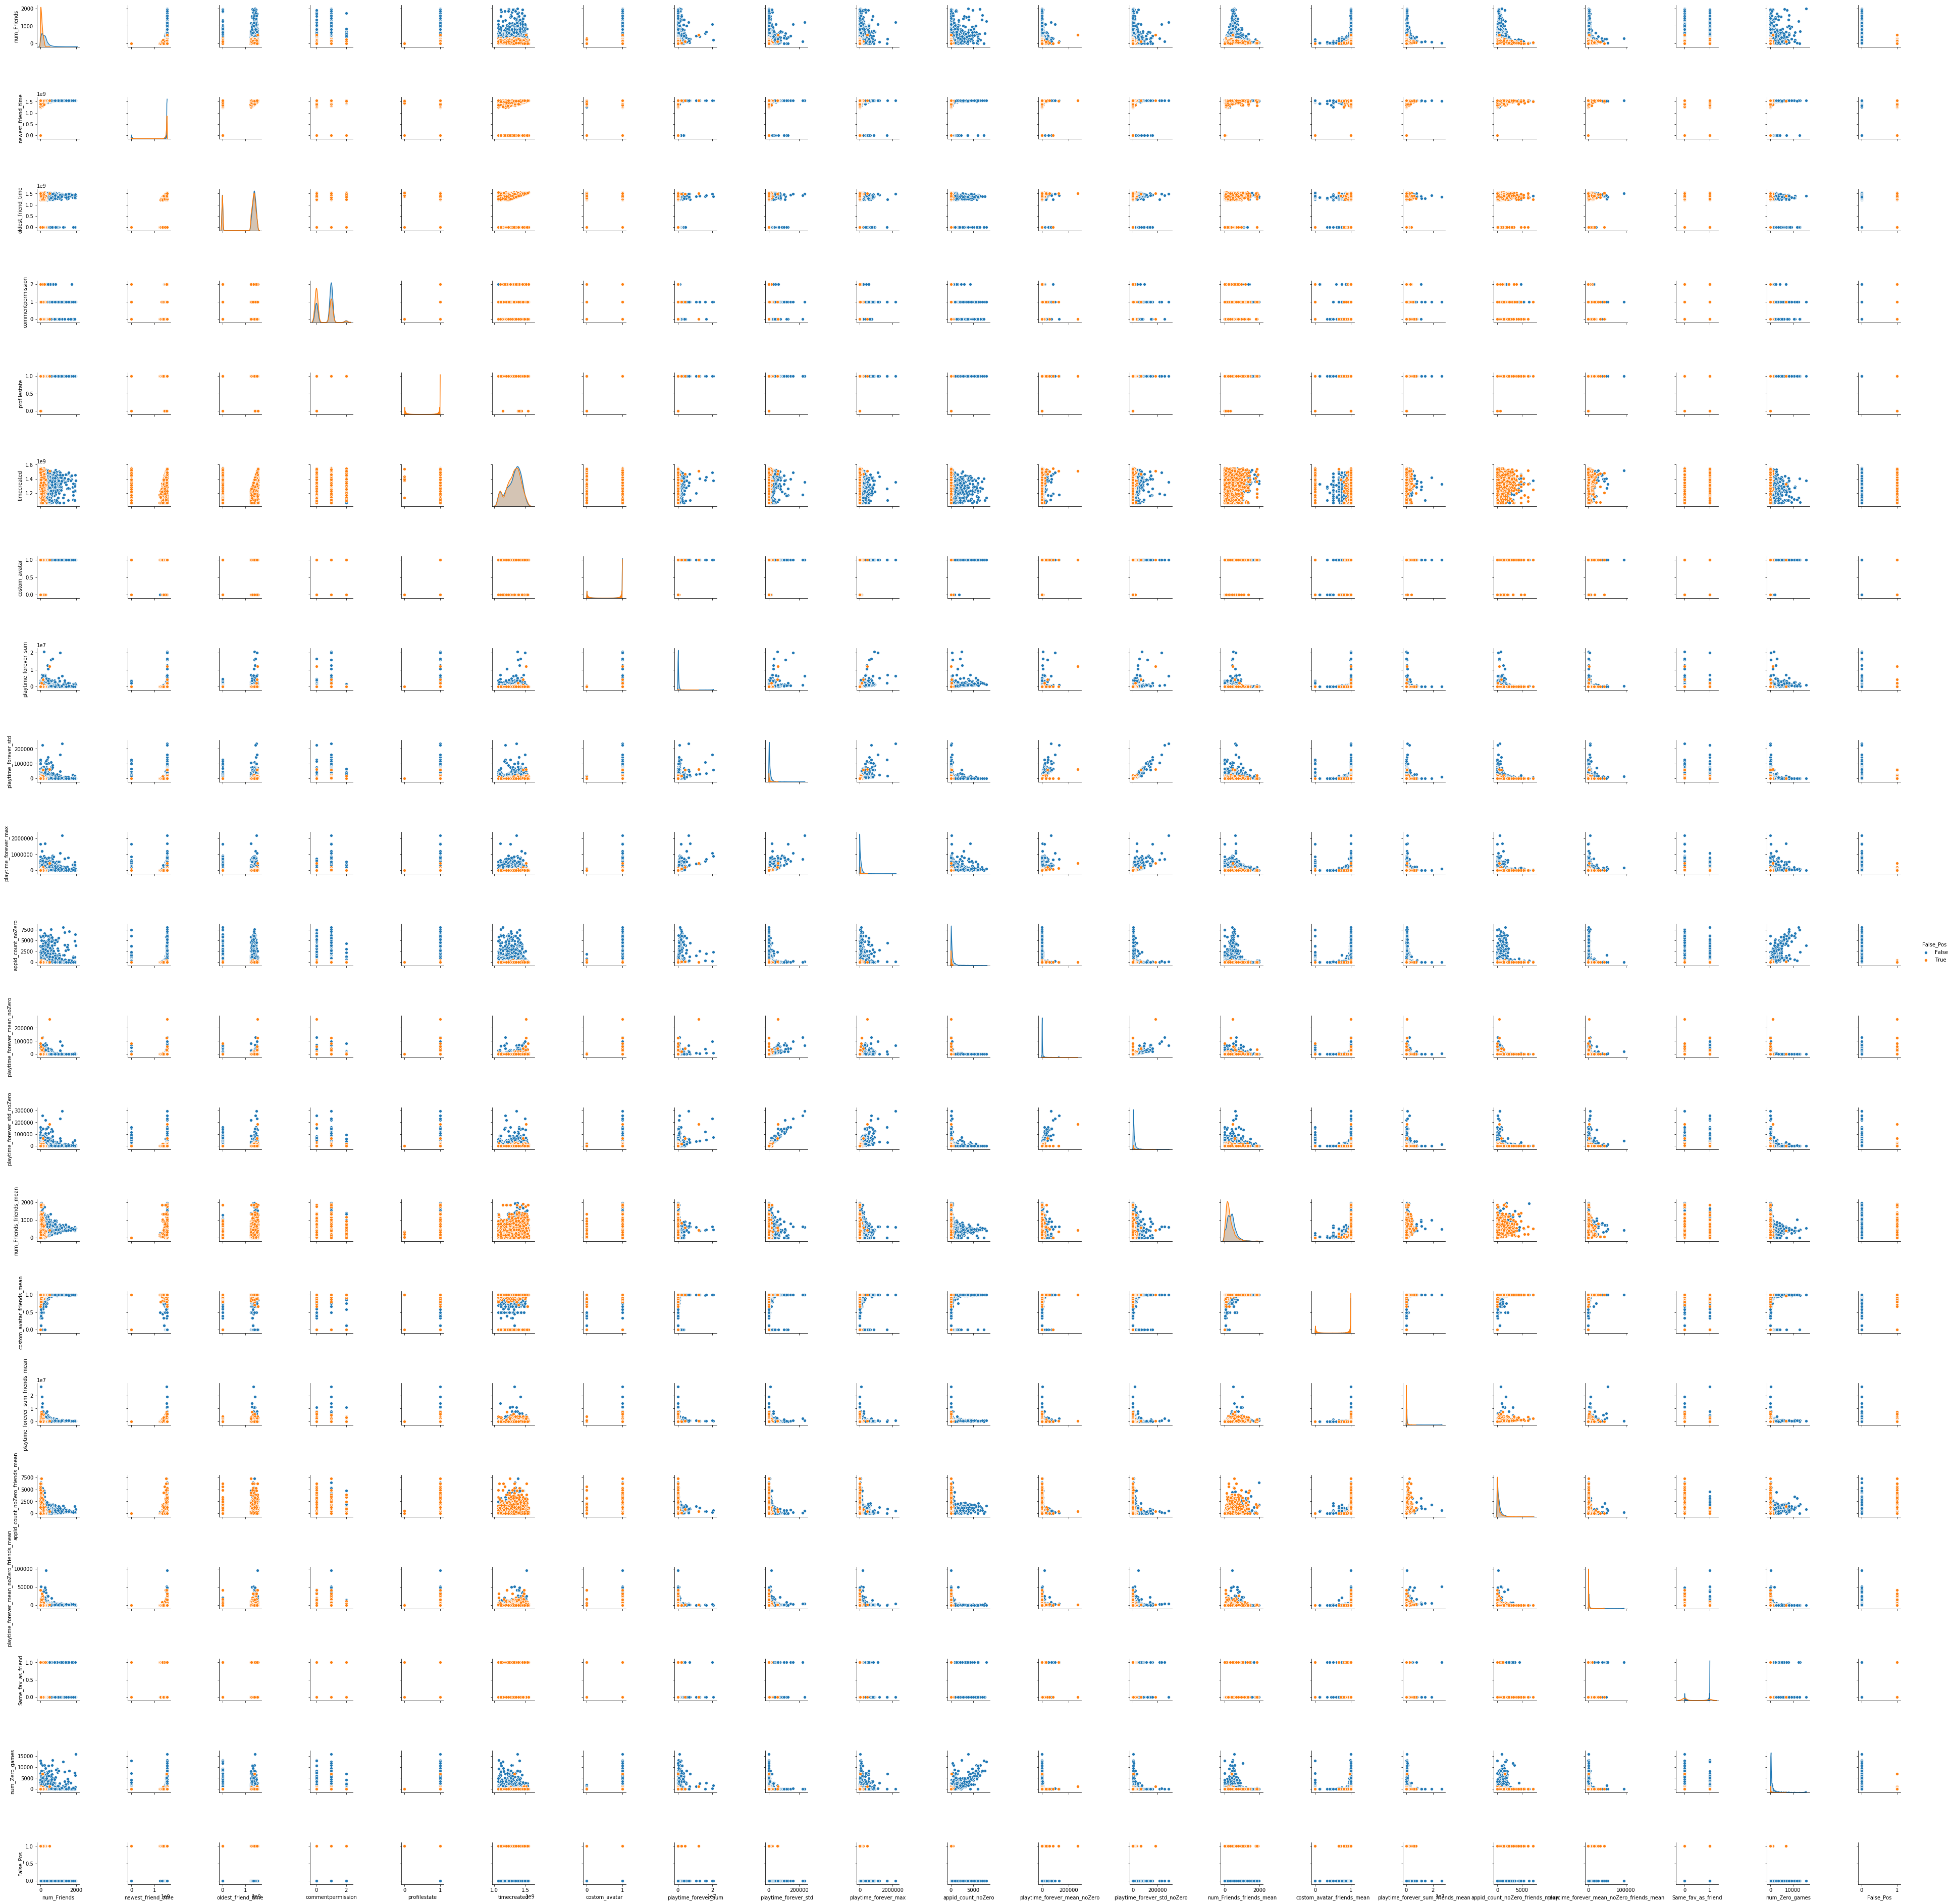

In [113]:
sns.pairplot(df_train[(df_train['isChurned'] == 0)][['num_Friends', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'profilestate', 'timecreated', 'costom_avatar',
       'playtime_forever_sum', 'playtime_forever_std', 'playtime_forever_max',
       'appid_count_noZero', 'playtime_forever_mean_noZero',
       'playtime_forever_std_noZero', 'num_Friends_friends_mean',
       'costom_avatar_friends_mean', 'playtime_forever_sum_friends_mean',
       'appid_count_noZero_friends_mean',
       'playtime_forever_mean_noZero_friends_mean', 'Same_fav_as_friend',
       'num_Zero_games','False_Pos']],hue='False_Pos')

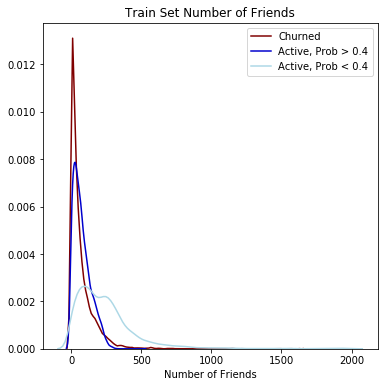

In [120]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_train['num_Friends'][df_train['isChurned'] == 1] , color="maroon", label="Churned",bins=100,hist=False,kde=True)
sns.distplot( df_train['num_Friends'][(df_train['isChurned'] == 0) & (df_train['False_Pos'])] , color="mediumblue", label="Active, Prob > 0.4",bins=100,hist=False,kde=True)
sns.distplot( df_train['num_Friends'][(df_train['isChurned'] == 0) & (~df_train['False_Pos'])] , color="lightblue", label="Active, Prob < 0.4",bins=100,hist=False,kde=True)
plt.legend()
#plt.plot([0.5, 0.5], [0, 800],'k--')
plt.xlabel("Number of Friends")
plt.title("Train Set Number of Friends")
plt.show()

In [140]:
pd.Series(abs(log_model.coef_[0]),index=X_train.columns).sort_values(ascending=False)

costom_avatar_friends_mean                   1.188820
appid_count_noZero                           1.074727
newest_friend_time                           1.072944
playtime_forever_max                         0.995804
num_Friends                                  0.481657
playtime_forever_sum                         0.294365
costom_avatar                                0.273161
profilestate                                 0.209117
oldest_friend_time                           0.160418
playtime_forever_mean_noZero                 0.121715
Same_fav_as_friend                           0.120123
num_Friends_friends_mean                     0.080587
playtime_forever_std                         0.070272
commentpermission                            0.057207
playtime_forever_std_noZero                  0.044874
num_Zero_games                               0.039519
timecreated                                  0.027717
playtime_forever_sum_friends_mean            0.018848
playtime_forever_mean_noZero

In [141]:
(df_train[['num_Friends', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'profilestate', 'timecreated', 'costom_avatar',
       'playtime_forever_sum', 'playtime_forever_std', 'playtime_forever_max',
       'appid_count_noZero', 'playtime_forever_mean_noZero',
       'playtime_forever_std_noZero', 'num_Friends_friends_mean',
       'costom_avatar_friends_mean', 'playtime_forever_sum_friends_mean',
       'appid_count_noZero_friends_mean',
       'playtime_forever_mean_noZero_friends_mean', 'Same_fav_as_friend',
       'num_Zero_games','False_Pos']].corr()['False_Pos'].apply(abs)).sort_values(ascending=False)

False_Pos                                    1.000000
playtime_forever_max                         0.154637
num_Friends                                  0.141795
playtime_forever_std                         0.120266
playtime_forever_std_noZero                  0.118965
appid_count_noZero                           0.113562
playtime_forever_sum                         0.094377
num_Zero_games                               0.086412
costom_avatar                                0.079173
profilestate                                 0.059708
playtime_forever_mean_noZero                 0.054402
num_Friends_friends_mean                     0.042120
commentpermission                            0.030439
playtime_forever_sum_friends_mean            0.029835
costom_avatar_friends_mean                   0.024556
appid_count_noZero_friends_mean              0.019769
playtime_forever_mean_noZero_friends_mean    0.018711
Same_fav_as_friend                           0.018409
newest_friend_time          

## OK drop std because high false pos rate and low power

In [184]:
X_train = df_train.drop(['steamid','playtime_forever_sum','playtime_forever_max','appid_count_noZero','num_Friends','playtime_forever_std','Prob_Active_Log', 'Prob_Churned_Log', 'False_Pos','playtime_forever_std_noZero','isPublic','isFriendsOnly','isPrivate','inClan','appid_count','playtime_forever_mean','lastlogoff','isChurned','appid_max','commentpermission_friends_mean','appid_count_friends_mean','friends_fav_appid','playtime_forever_mean_friends_mean','isChurned_friends_mean','inClan_friends_mean'],axis='columns')
X_test = df_test.drop(['steamid','playtime_forever_sum','playtime_forever_max','appid_count_noZero','num_Friends','Prob_Active_Log', 'Prob_Churned_Log','playtime_forever_std','playtime_forever_std_noZero','isPublic','isFriendsOnly','isPrivate','inClan','appid_count','playtime_forever_mean','lastlogoff','isChurned','appid_max','commentpermission_friends_mean','appid_count_friends_mean','friends_fav_appid','playtime_forever_mean_friends_mean','isChurned_friends_mean','inClan_friends_mean'],axis='columns')
y_train = df_train['isChurned']
y_test = df_test['isChurned']

In [185]:
X_train.columns

Index(['newest_friend_time', 'oldest_friend_time', 'commentpermission',
       'profilestate', 'timecreated', 'costom_avatar',
       'playtime_forever_mean_noZero', 'num_Friends_friends_mean',
       'costom_avatar_friends_mean', 'playtime_forever_sum_friends_mean',
       'appid_count_noZero_friends_mean',
       'playtime_forever_mean_noZero_friends_mean', 'Same_fav_as_friend',
       'num_Zero_games'],
      dtype='object')

In [186]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [187]:
log_model = LogisticRegression(random_state=10,solver='lbfgs')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/anaconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [188]:
log_model.fit(X_train_scaled,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

# Validate on Training Data (Equalized Population Ratio)

[[8096 2974]
 [3160 7910]]


              precision    recall  f1-score   support

           0       0.72      0.73      0.73     11070
           1       0.73      0.71      0.72     11070

   micro avg       0.72      0.72      0.72     22140
   macro avg       0.72      0.72      0.72     22140
weighted avg       0.72      0.72      0.72     22140



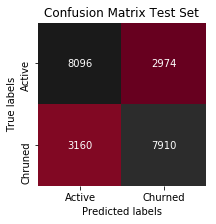

In [189]:
from sklearn.metrics import confusion_matrix, classification_report
axis = plt.figure(figsize=(3,3))
log_pred = log_model.predict(X_train_scaled)
cm = confusion_matrix(y_train,log_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d',ax = ax,cmap='RdGy',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Test Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_train,log_pred))

In [190]:
prob_class_active = []
prob_class_churned = []
for x in log_model.predict_proba(X_train_scaled):
    prob_class_active.append(x[0])
    prob_class_churned.append(x[1])
df_train['Prob_Active_Log'] = prob_class_active
df_train['Prob_Churned_Log'] = prob_class_churned

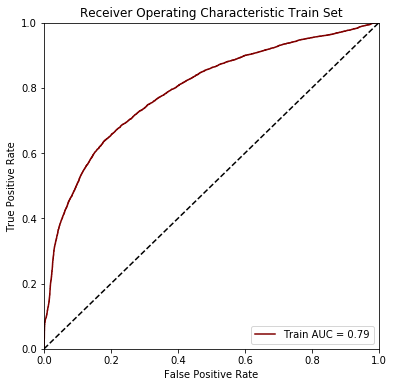

In [191]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_train, df_train['Prob_Churned_Log'], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic Train Set')
plt.plot(fpr, tpr, 'maroon',label = 'Train AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

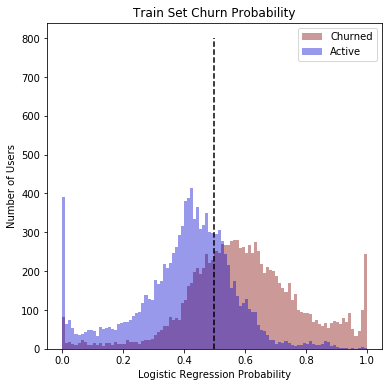

In [192]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_train['Prob_Churned_Log'][df_train['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_train['Prob_Churned_Log'][df_train['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Train Set Churn Probability")
plt.show()

# Validate on Test Data (True Population Ratio)

[[10794  4150]
 [  856  1912]]


              precision    recall  f1-score   support

           0       0.93      0.72      0.81     14944
           1       0.32      0.69      0.43      2768

   micro avg       0.72      0.72      0.72     17712
   macro avg       0.62      0.71      0.62     17712
weighted avg       0.83      0.72      0.75     17712



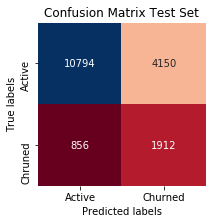

In [193]:
axis = plt.figure(figsize=(3,3))
log_pred = log_model.predict(X_test_scaled)
cm = confusion_matrix(y_test,log_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d',ax = ax,cmap='RdBu',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Test Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_test,log_pred))

In [194]:
prob_class_active = []
prob_class_churned = []
for x in log_model.predict_proba(X_test_scaled):
    prob_class_active.append(x[0])
    prob_class_churned.append(x[1])
df_test['Prob_Active_Log'] = prob_class_active
df_test['Prob_Churned_Log'] = prob_class_churned

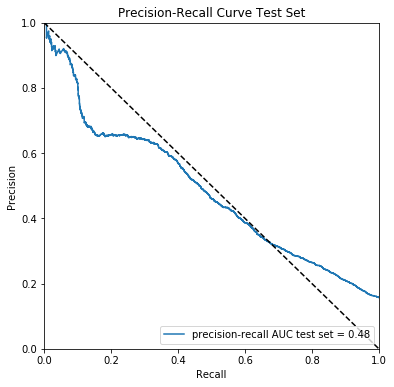

In [195]:
precision, recall, threshold = metrics.precision_recall_curve(y_test, df_test['Prob_Churned_Log'], pos_label=1)
roc_auc = metrics.auc(recall, precision)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Precision-Recall Curve Test Set')
plt.plot(recall, precision, label = 'precision-recall AUC test set = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [196]:
df_train['False_Pos'] = ((df_train['Prob_Churned_Log'] > 0.4) & (df_train['isChurned'] == 0))